In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import torch
import numpy as np
import cvxpy as cp
from osmm import OSMM

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
CPU = torch.device('cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    device = CPU
print("device =", device)

device = cpu


## generate data

In [4]:
N = 1000000
n = 200

In [5]:
np.random.seed(0)
pi = np.random.uniform(0, 1, N)
pi = pi / np.sum(pi)

mean_returns = np.random.uniform(0.9, 1.1, n)

returns_tmp = np.exp(np.random.randn(n, N))
mean_tmp = np.sum(returns_tmp * pi, axis=1)
returns = (returns_tmp.T / mean_tmp * mean_returns).T

W = np.zeros((n + 1, N))
W[0:n, :] = returns
W[n, :] = pi

## define g and f

In [6]:
def my_g_cvxpy():
    x_var = cp.Variable(n, nonneg=True)
    g = 0
    constr = [cp.sum(x_var) == 1]
    return x_var, g, constr

In [7]:
def my_f_torch(b_torch, W_torch):
    r_torch = W_torch[0:n, :]
    pi_torch = W_torch[n, :]
    objf = -torch.sum(torch.log(torch.matmul(r_torch.T, b_torch)) * pi_torch)
    return objf

## consturct osmm object and pass in data

In [8]:
osmm_prob = OSMM(my_f_torch, my_g_cvxpy)
osmm_prob.f_torch.W = W

## solve

In [9]:
init_val = np.ones(n) / n
osmm_prob.solve(init_val, verbose=True, 
#                 use_termination_criteria=False
               )

iter = 10, objf = -5.715e-02, lower bound = -5.752e-02, RMS residual = 7.865e-04, ||G||_F = 7.457e+00
      Terminated. Num iterations = 12, objf = -5.716e-02, lower bound = -5.752e-02, RMS residual = 4.782e-04.
      Time elapsed (secs): 19.391256.



-0.05715961754322052

## plot result

In [10]:
total_iters = osmm_prob.method_results["total_iters"]
iters = np.array([i for i in range(0, total_iters + 1)])

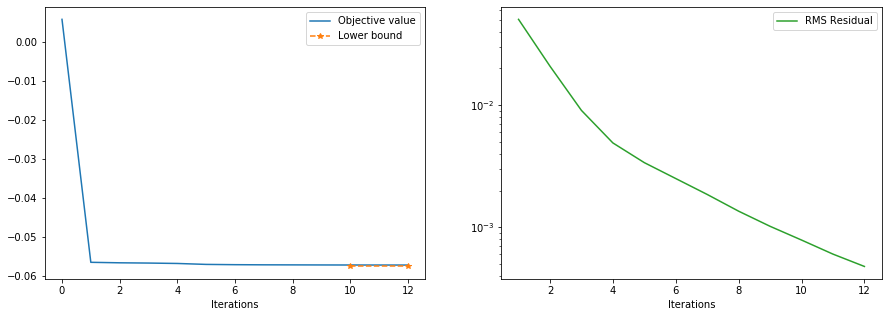

In [11]:
fig = plt.figure(tight_layout=False, figsize=(15, 5))
gs = gridspec.GridSpec(1, 2)

plot1 = fig.add_subplot(gs[0, 0])
plot1.plot(iters, osmm_prob.method_results["objf_iters"][0:total_iters + 1], label="Objective value")
lower_bound_idxs = [i for i in range(0, total_iters + 1, 10)] + [total_iters]
plot1.plot(iters[lower_bound_idxs], osmm_prob.method_results["lower_bound_iters"][lower_bound_idxs], 
           '--*', label="Lower bound")

plot1.set_xlabel("Iterations")
plot1.legend()

#=========================================================================================================
plot2 = fig.add_subplot(gs[0, 1])
start_idx = 1
rms_res_running_min = np.array(osmm_prob.method_results["rms_res_iters"][0:total_iters + 1])
for i in range(start_idx, total_iters + 1):
    rms_res_running_min[i] = np.min(osmm_prob.method_results["rms_res_iters"][start_idx:i + 1])

plot2.plot(iters[start_idx::], rms_res_running_min[start_idx::], label="RMS Residual", color='#2ca02c')

plot2.set_xlabel("Iterations")
plot2.set_yscale("log")
plot2.legend()

/Users/xinyueshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


Text(0.5, 0, 'Log Return')

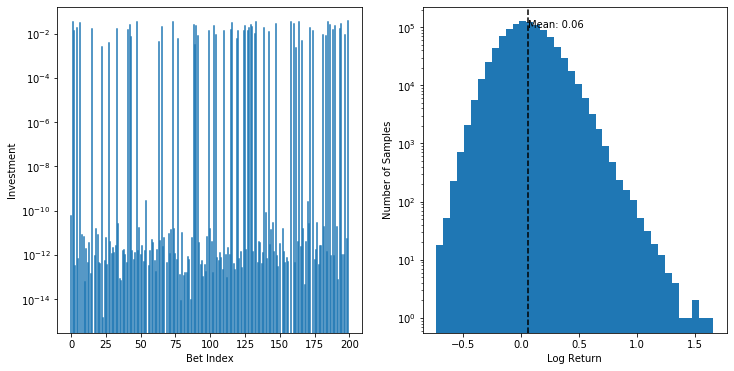

In [12]:
fig = plt.figure(tight_layout=False, figsize=(12, 6))
gs = gridspec.GridSpec(1, 2)

plot1 = fig.add_subplot(gs[0, 0])
plot1.stem([i for i in range(n)], osmm_prob.method_results["soln"], markerfmt=' ')
plot1.set_ylabel("Investment")
plot1.set_xlabel("Bet Index")
plot1.set_yscale("log")

payoff_outcomes = np.log(W[0:n, :].T.dot(osmm_prob.method_results["soln"]))
payoff_mean = np.sum(payoff_outcomes * W[n, :])
plot2 = fig.add_subplot(gs[0, 1])
plot2.hist(payoff_outcomes, bins=40)
plot2.set_yscale("log")
plot2.axvline(payoff_mean, color='k', linestyle='dashed')
plot2.text(payoff_mean, int(N * 0.1), 'Mean: {:.2f}'.format(payoff_mean))
plot2.set_ylabel("Number of Samples")
plot2.set_xlabel("Log Return")